In [13]:
import pandas as pd


In [14]:
df = pd.read_csv("registros_rio_6746.csv")
#modificando las columns del df:
df["date"] = pd.to_datetime(df["date"])

df = df.sort_values(by="date")
df = df.drop(columns=['es_null', 'year'])

df['altura_7_dias'] = df['altura_value'].shift(periods=-7)
df['precipitaciones_7_dias'] = df['precipitaciones_value'].shift(periods=-7)
df = df.iloc[:1001].copy() #elimino las ultimas 7 ya que tienen datos del futuro
df

,date,rio_id,lat,lon,altura_value,precipitaciones_value,altura_7_dias,precipitaciones_7_dias
0,2023-01-02,6746-2123,-36.397778,-67.140278,-0.06,0.0,-0.06,0.7
1,2023-01-03,6746-2123,-36.397778,-67.140278,-0.06,0.0,-0.06,3.4
2,2023-01-04,6746-2123,-36.397778,-67.140278,-0.06,0.0,-0.06,0.0
3,2023-01-05,6746-2123,-36.397778,-67.140278,-0.06,0.1,-0.06,0.0
4,2023-01-06,6746-2123,-36.397778,-67.140278,-0.06,0.1,-0.06,0.0
...,...,...,...,...,...,...,...,...
996,2025-09-24,6746-2123,-36.397778,-67.140278,0.84,0.0,0.75,0.0
997,2025-09-25,6746-2123,-36.397778,-67.140278,0.81,0.0,0.78,0.0
998,2025-09-26,6746-2123,-36.397778,-67.140278,0.77,4.9,0.81,0.0
999,2025-09-27,6746-2123,-36.397778,-67.140278,0.77,0.0,0.83,0.4


In [15]:
def obtener_estacion(fecha):
    mes = fecha.month
    dia = fecha.day
    
    if (mes == 12 and dia >= 21) or (mes <= 3 and (mes < 3 or dia <= 20)):
        return 0  # Verano
    elif (mes == 3 and dia >= 21) or (mes <= 6 and (mes < 6 or dia <= 20)):
        return 1  # Otoño
    elif (mes == 6 and dia >= 21) or (mes <= 9 and (mes < 9 or dia <= 20)):
        return 2  # Invierno
    else:
        return 3  # Primavera

# Agregar la columna de estación
df['estacion'] = df['date'].apply(obtener_estacion)

# Verificar
print(df[['date', 'estacion']].head(20))
print(f"\nDistribución de estaciones:")
print(df['estacion'].value_counts().sort_index())

         date  estacion
0  2023-01-02         0
1  2023-01-03         0
2  2023-01-04         0
3  2023-01-05         0
4  2023-01-06         0
5  2023-01-07         0
6  2023-01-08         0
7  2023-01-09         0
8  2023-01-10         0
9  2023-01-11         0
10 2023-01-12         0
11 2023-01-13         0
12 2023-01-14         0
13 2023-01-15         0
14 2023-01-16         0
15 2023-01-17         0
16 2023-01-18         0
17 2023-01-19         0
18 2023-01-20         0
19 2023-01-21         0

Distribución de estaciones:
estacion
0    259
1    276
2    276
3    190
Name: count, dtype: int64


In [16]:
columnas_a_eliminar = ['rio_id', 'lat', 'lon']
df = df.drop(columns=columnas_a_eliminar)

In [17]:
import pandas as pd
import numpy as np

# Asumiendo que tu dataframe se llama 'df'
# Primero, eliminemos la columna errónea
df = df.drop('altura_7_dias', axis=1)

# Asegurémonos de que esté ordenado por fecha
df = df.sort_values('date').reset_index(drop=True)

# Seleccionamos solo las columnas numéricas relevantes
features = ['altura_value', 'precipitaciones_value', 'estacion']

# Función para crear ventanas
def crear_ventanas(df, features, window_size=4):
    X = []
    y = []
    
    # Empezamos desde window_size porque necesitamos 7 días previos
    for i in range(window_size, len(df)):
        # Tomamos los últimos 7 días (de i-7 a i-1)
        ventana = df[features].iloc[i-window_size:i].values
        
        # Aplanamos la ventana en un solo vector
        # Shape: (14 días, 2 features) -> (14 features)
        X.append(ventana.flatten())
        
        # El target es la altura del día actual (día i)
        y.append(df['altura_value'].iloc[i])
    
    return np.array(X), np.array(y)

# Crear las ventanas
X, y = crear_ventanas(df, features, window_size=7)

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nEjemplo de una fila de X (14 valores):")
print(X[0])
print(f"\nSu correspondiente y (altura a predecir):")
print(y[0])

Shape de X (features): (994, 21)
Shape de y (target): (994,)

Ejemplo de una fila de X (14 valores):
[-0.06  0.    0.   -0.06  0.    0.   -0.06  0.    0.   -0.06  0.1   0.
 -0.06  0.1   0.   -0.06  0.    0.   -0.06  0.    0.  ]

Su correspondiente y (altura a predecir):
-0.06


In [18]:
from sklearn.preprocessing import MinMaxScaler

# Split temporal (80% train, 20% test)
split_idx = int(0.8 * len(X))

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Train: {X_train.shape[0]} muestras")
print(f"Test: {X_test.shape[0]} muestras")

# Escalado (IMPORTANTE: fit solo en train, transform en ambos)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)  # Solo transform, NO fit

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("\nDatos listos para entrenar!")

Train: 795 muestras
Test: 199 muestras

Datos listos para entrenar!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Crear el modelo
model = keras.Sequential([
    layers.Input(shape=(21,)),  # 21 features de entrada
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # 1 salida: altura predicha
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error para regresión
    metrics=['mae']  # Mean Absolute Error para monitorear
)

# Ver la arquitectura
model.summary()

# Entrenar
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # 20% del train para validación
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,033 (15.75 KB)

 Trainable params: 4,033 (15.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 0.0632 - mae: 0.1574 - val_loss: 0.0290 - val_mae: 0.1371
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0027 - mae: 0.0372 - val_loss: 0.0154 - val_mae: 0.0796
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011 - mae: 0.0175 - val_loss: 0.0150 - val_mae: 0.0776
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.9127e-04 - mae: 0.0138 - val_loss: 0.0135 - val_mae: 0.0740
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.4794e-04 - mae: 0.0124 - val_loss: 0.0131 - val_mae: 0.0731
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.4549e-04 - mae: 0.0116 - val_loss: 0.0126 - val_mae: 0.0719
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.0210e-04 - mae: 0.0111 - val_loss: 0.0114 - val_mae: 0.0680
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.4860e-04 - mae: 0.0102 - val_loss: 0.0109 - val_mae: 0.0668
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluar en el test set
y_pred_scaled = model.predict(X_test_scaled)

# Desescalar las predicciones y los valores reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calcular el error en unidades reales
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_real = mean_absolute_error(y_test_real, y_pred)
rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred))

print(f"MAE en metros: {mae_real:.4f}")
print(f"RMSE en metros: {rmse_real:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
MAE en metros: 0.0864
RMSE en metros: 0.0913


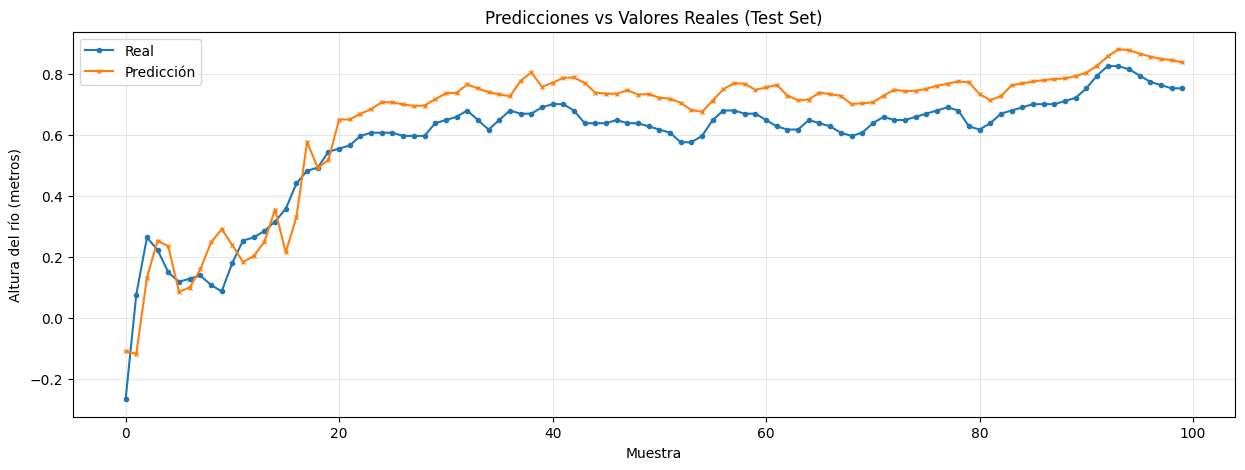

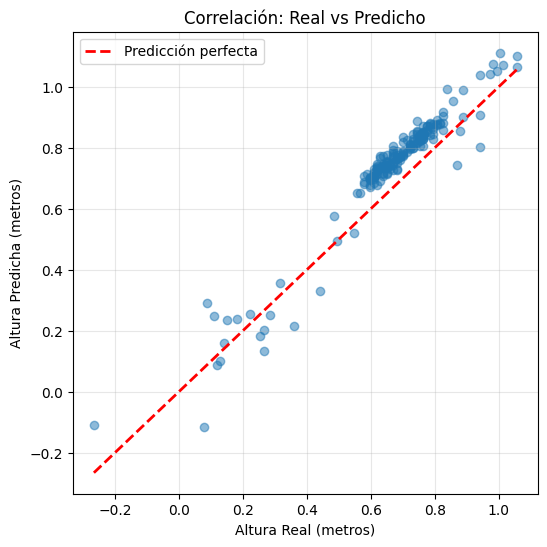

In [ ]:
# Comparar predicciones vs valores reales
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# Mostrar solo las primeras 100 predicciones para que se vea claro
n_mostrar = 100

plt.plot(y_test_real[:n_mostrar], label='Real', marker='o', markersize=3)
plt.plot(y_pred[:n_mostrar], label='Predicción', marker='x', markersize=3)
plt.xlabel('Muestra')
plt.ylabel('Altura del río (metros)')
plt.title('Predicciones vs Valores Reales (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Scatter plot para ver correlación
plt.figure(figsize=(6, 6))
plt.scatter(y_test_real, y_pred, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], 
        [y_test_real.min(), y_test_real.max()], 
        'r--', lw=2, label='Predicción perfecta')
plt.xlabel('Altura Real (metros)')
plt.ylabel('Altura Predicha (metros)')
plt.title('Correlación: Real vs Predicho')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Crear un DataFrame comparativo
import pandas as pd

comparacion = pd.DataFrame({
    'Altura_Real': y_test_real.flatten(),
    'Altura_Predicha': y_pred.flatten(),
    'Error_Absoluto': np.abs(y_test_real.flatten() - y_pred.flatten())
})

# Ver las primeras filas
print(comparacion.head(20))

# Estadísticas del error
print("\n--- Estadísticas del Error ---")
print(comparacion['Error_Absoluto'].describe())

# Ver los 10 peores errores
print("\n--- 10 Peores Predicciones ---")
peores = comparacion.nlargest(10, 'Error_Absoluto')
print(peores)

# Ver los 10 mejores predicciones
print("\n--- 10 Mejores Predicciones ---")
mejores = comparacion.nsmallest(10, 'Error_Absoluto')
print(mejores)

# Opcional: guardar a CSV
# comparacion.to_csv('predicciones_vs_reales.csv', index=False)

    Altura_Real  Altura_Predicha  Error_Absoluto
0       -0.2652        -0.108747        0.156453
1        0.0780        -0.116534        0.194534
2        0.2652         0.133489        0.131711
3        0.2236         0.255071        0.031471
4        0.1508         0.235566        0.084766
5        0.1196         0.087150        0.032450
6        0.1300         0.100973        0.029027
7        0.1404         0.160582        0.020182
8        0.1092         0.248787        0.139587
9        0.0884         0.292278        0.203878
10       0.1820         0.239661        0.057661
11       0.2548         0.184431        0.070369
12       0.2652         0.203946        0.061254
13       0.2860         0.250982        0.035018
14       0.3172         0.356660        0.039460
15       0.3588         0.216403        0.142397
16       0.4420         0.331420        0.110580
17       0.4836         0.577663        0.094063
18       0.4940         0.493269        0.000731
19       0.5460     

In [ ]:
print(df["altura_value"].min())
print(df["altura_value"].max())
rango_total = 1.14 - (-0.13)
error_porcentual = (0.0567 / rango_total) * 100

print(f"Rango del río: {rango_total:.2f} metros")
print(f"Error promedio (MAE): {0.0567:.4f} metros")
print(f"Error relativo: {error_porcentual:.2f}%")

-0.13
1.14
Rango del río: 1.27 metros
Error promedio (MAE): 0.0567 metros
Error relativo: 4.46%
